In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
sns.set()
from scipy import stats 
from scipy.stats.mstats import winsorize
from scipy.stats import mstats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier

from interpret.blackbox import LimeTabular
from interpret import show
import shap

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv(r"C:\Users\INTELLECT\British Airline\data\customer_booking.csv",  encoding='ISO-8859-1')


In [3]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,0,1,5.62,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

# Data Processing

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [8]:
df['trip_type'].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [9]:
mapping = {
    'RoundTrip': 1,
    'CircleTrip': 2,
    'OneWay': 3,
}

df['trip_type'] = df['trip_type'].map(mapping)

In [10]:
df['trip_type'].unique()

array([1, 2, 3], dtype=int64)

In [11]:
df['sales_channel'].unique()

array(['Internet', 'Mobile'], dtype=object)

In [12]:
mapping = {
    'Internet': 1,
    'Mobile': 2,
}

df['sales_channel']= df['sales_channel'].map(mapping)

In [13]:
df['sales_channel'].unique()

array([1, 2], dtype=int64)

In [14]:
df.describe()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,1.112360,1.017800,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,0.315812,0.181559,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,1.000000,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,1.000000,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,1.000000,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,1.000000,1.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,2.000000,3.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


# Checking for Null values

In [15]:
round((df.isnull().sum() * 100/ len(df)),2).sort_values(ascending=False)

num_passengers           0.0
sales_channel            0.0
trip_type                0.0
purchase_lead            0.0
length_of_stay           0.0
flight_hour              0.0
flight_day               0.0
route                    0.0
booking_origin           0.0
wants_extra_baggage      0.0
wants_preferred_seat     0.0
wants_in_flight_meals    0.0
flight_duration          0.0
booking_complete         0.0
dtype: float64

In [16]:
# Checking data types
df.dtypes


num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

# Handling duplicates

In [17]:

print("Duplicates in dataset:", df.duplicated().sum())

Duplicates in dataset: 719


In [18]:
df = df.drop_duplicates(keep = 'first')

In [19]:
print("Duplicates in dataset:", df.duplicated().sum())

Duplicates in dataset: 0


In [20]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,1,1,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,1,1,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,1,1,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,1,1,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,1,1,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,1,1,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49996,1,1,1,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49997,1,1,1,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49998,1,1,1,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


In [21]:
# Seperate numeriacl from categorical features
continuous_vars=df.select_dtypes(['float64','int']).columns
print('The Continous Variables are: ', continuous_vars)
categorical_vars=df.select_dtypes('object').columns
print()
print('The Catigorical Variables are: ', categorical_vars)

The Continous Variables are:  Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'wants_extra_baggage',
       'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration',
       'booking_complete'],
      dtype='object')

The Catigorical Variables are:  Index(['route', 'booking_origin'], dtype='object')


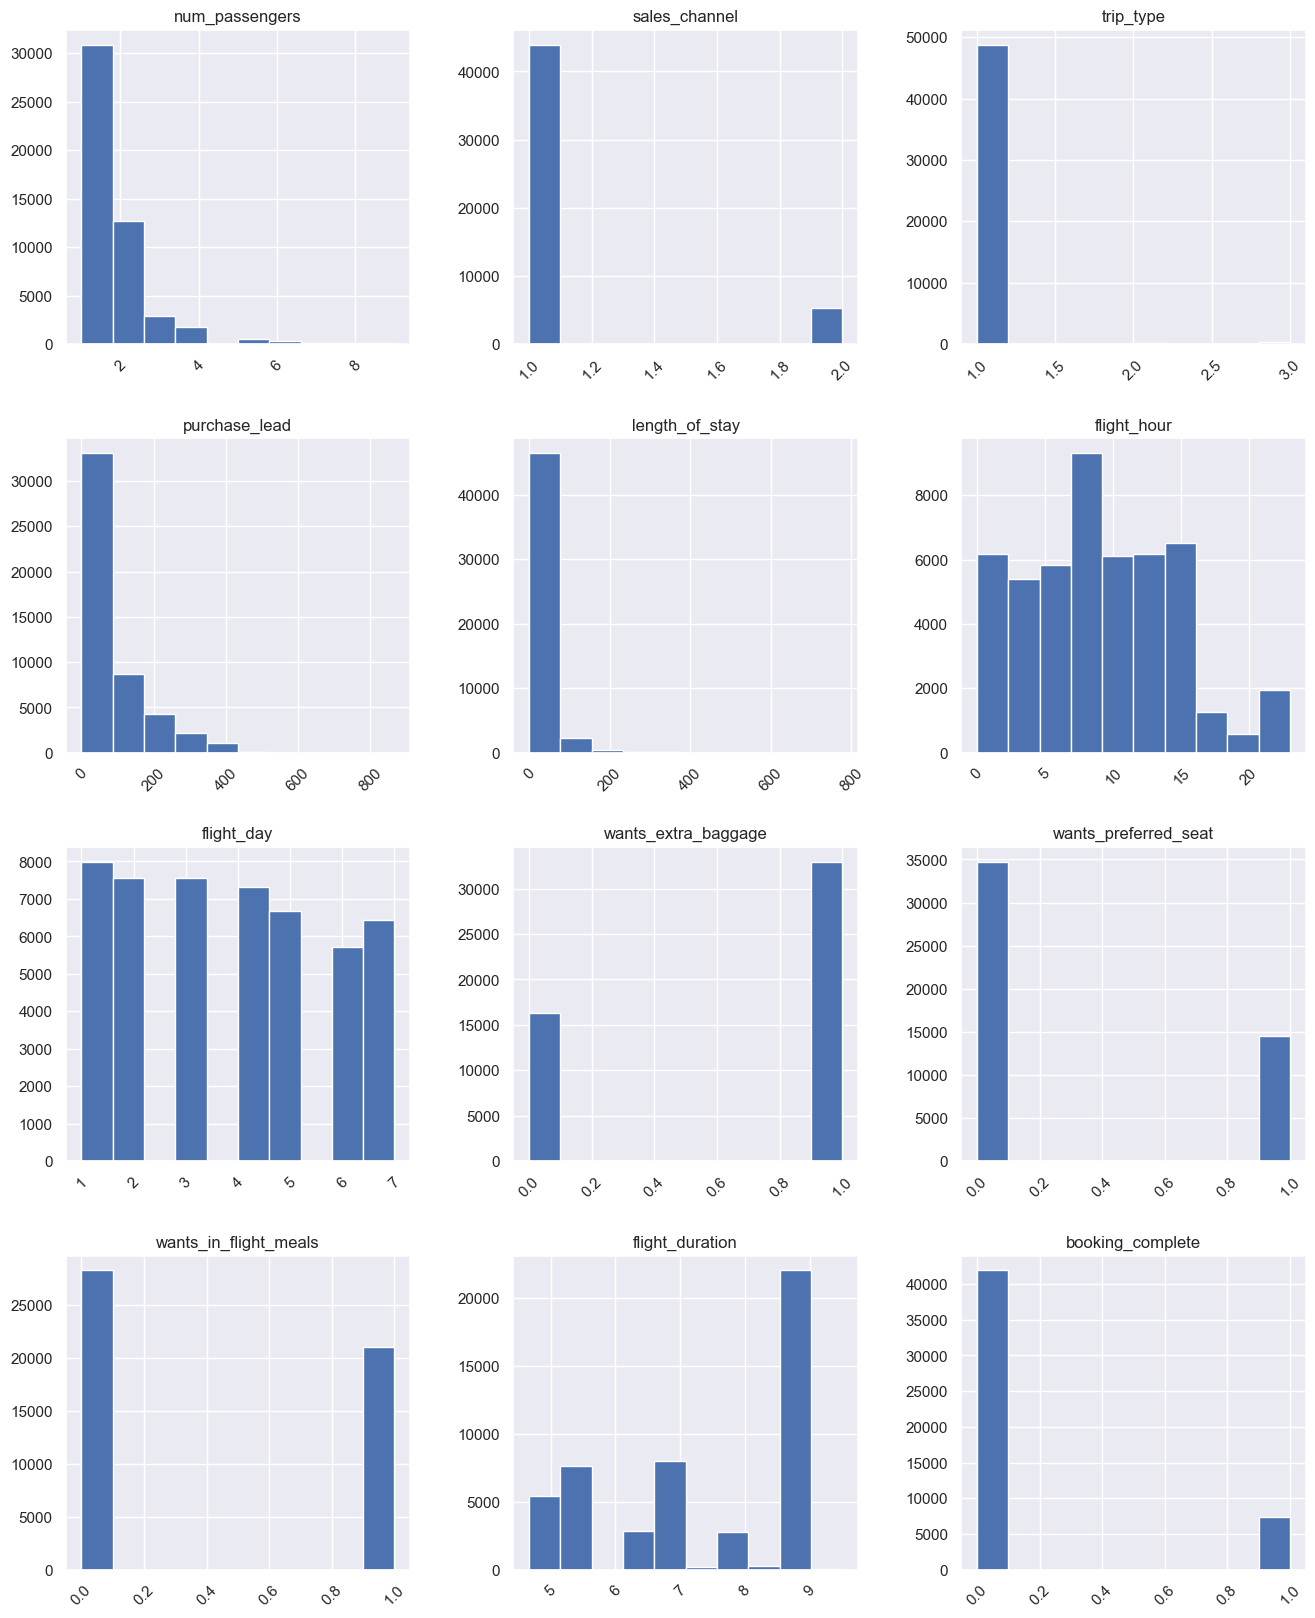

In [22]:
# inspecting distribution of data in the numerical features
# visual approach to explore distribution in the features
df.hist(figsize=(16,20), xrot=45)
plt.show()

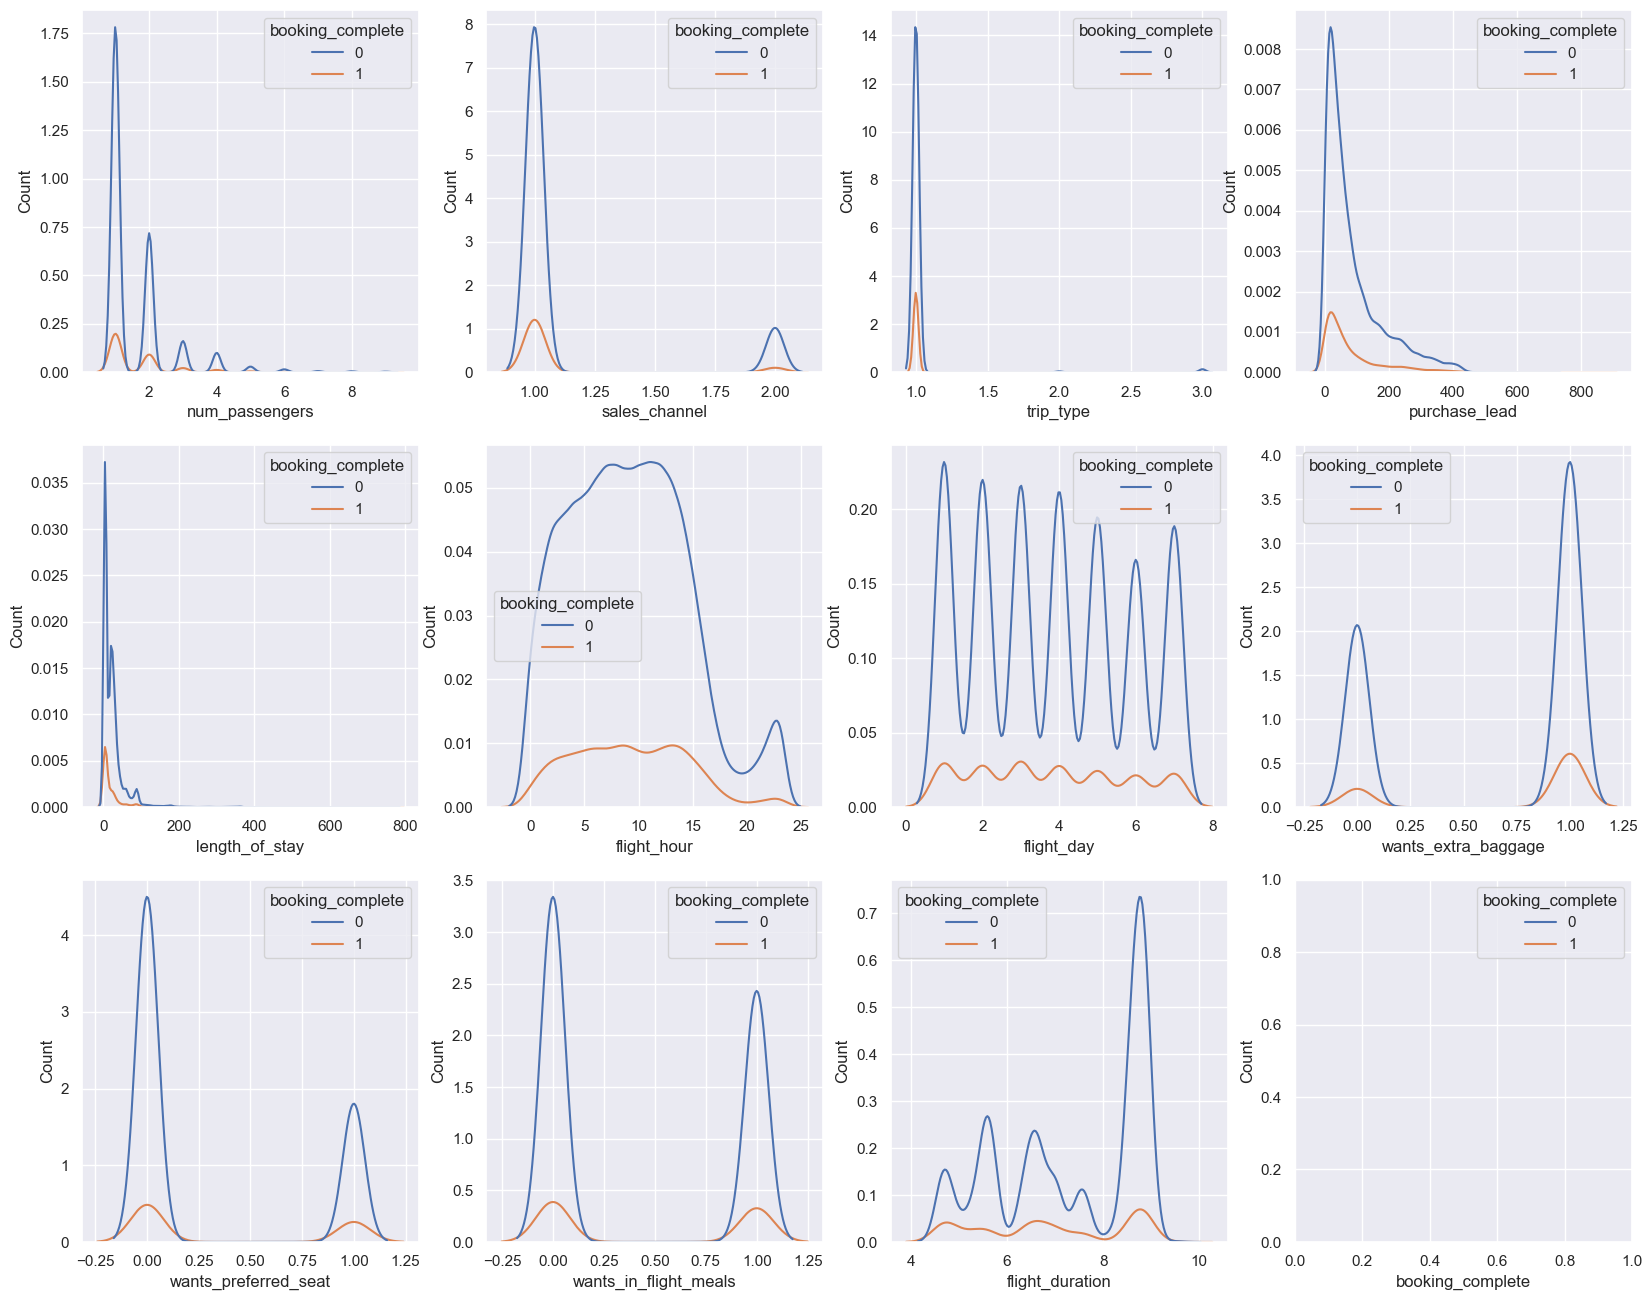

In [23]:
i = 1
plt.figure(figsize=(20, 16))
for col in continuous_vars:
    plt.subplot(3, 4, i)
    sns.kdeplot(x=col, hue='booking_complete', data=df)
    plt.xlabel(col)
    plt.ylabel("Count")
    i += 1
    if i > 12:
        break  # Stop plotting after 12 subplots


In [24]:
# Encoding the categorical columns

le = LabelEncoder()

for col in categorical_vars:
    df[col] = le.fit_transform(df[col].astype(str))

In [25]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,1,1,262,19,7,6,0,61,1,0,0,5.52,0
1,1,1,1,112,20,3,6,0,61,0,0,0,5.52,0
2,2,1,1,243,22,17,3,0,36,1,1,0,5.52,0
3,1,1,1,96,31,4,6,0,61,0,0,1,5.52,0
4,2,1,1,68,22,15,3,0,36,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,1,1,27,6,9,6,720,4,1,0,1,5.62,0
49996,1,1,1,111,6,4,7,720,4,0,0,0,5.62,0
49997,1,1,1,24,6,22,6,720,4,0,0,1,5.62,0
49998,1,1,1,15,6,11,1,720,4,1,0,1,5.62,0


In [26]:
# Distribution of labels in the target variable
df.booking_complete.value_counts()

0    41890
1     7391
Name: booking_complete, dtype: int64

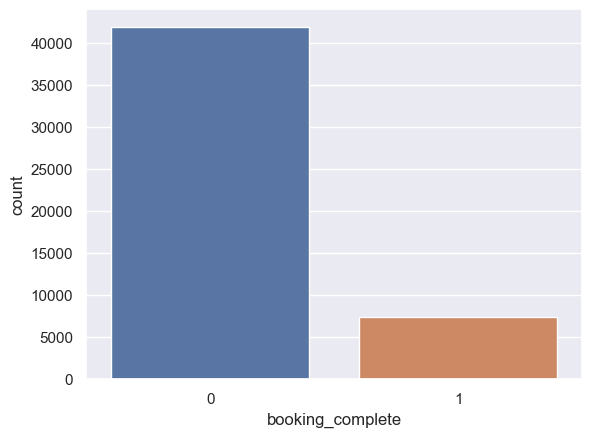

In [27]:
# Visualization of the distribution of labels in the target variable
sns.countplot(x=df['booking_complete'])
plt.show()

# Model Building

In [28]:
#Separating the features from the Target

x=df.drop('booking_complete',axis =1)
y=df['booking_complete']

In [29]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=50)

In [30]:
minmax = MinMaxScaler(feature_range=(0,1))
x_train_minmax= minmax.fit_transform(x_train)
x_test_minmax= minmax.transform(x_test)

The accuracy is:  0.8493628763899034
The precision is:  0.4836795252225519
The recall is:  0.0883468834688347
The f1_score is:  0.14940421631530704
The report is:                precision    recall  f1-score   support

           0       0.86      0.98      0.92     10476
           1       0.48      0.09      0.15      1845

    accuracy                           0.85     12321
   macro avg       0.67      0.54      0.53     12321
weighted avg       0.80      0.85      0.80     12321

The confusion_matrix is:  [[10302   174]
 [ 1682   163]]
The roc is:  0.535868745285391
The loss is:  5.202833221240734


<AxesSubplot:>

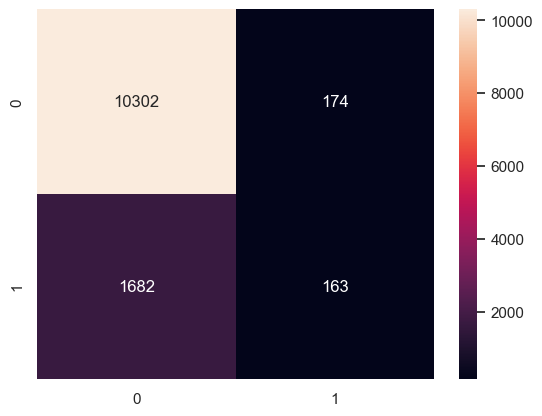

In [31]:
rf=RandomForestClassifier()
rf.fit(x_train_minmax,y_train)
y_predictions=rf.predict(x_test_minmax)


accuracy=accuracy_score(y_test,y_predictions)
recall=recall_score(y_test, y_predictions)
f1=f1_score(y_test, y_predictions)
precision=precision_score(y_test, y_predictions)
report=classification_report(y_test, y_predictions)
confusion = confusion_matrix(y_test, y_predictions)


roc=roc_auc_score(y_test, y_predictions,  average = 'macro')
loss=log_loss(y_test, y_predictions)



print("The accuracy is: ",accuracy)
print("The precision is: ",precision)
print("The recall is: ",recall)
print("The f1_score is: ",f1)
print("The report is: ",report)
print("The confusion_matrix is: ",confusion)

print("The roc is: ",roc)
print("The loss is: ",loss)

sns.heatmap(confusion,annot=True,fmt="g")

# XAI Implementation

In [32]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)

RandomForestClassifier()

In [33]:
lime = LimeTabular(predict_fn = rf.predict_proba, data = x_train, random_state = 1)

In [34]:
lime_local=lime.explain_local(x_train[-20:], y_train[-20:], name = "Lime")
show(lime_local)

<!-- http://127.0.0.1:7001/2331151731728/ -->

In [35]:
explainer = shap.TreeExplainer(rf)

In [36]:
start_index = 1
end_index = 2
shap_values = explainer.shap_values(x_test[start_index:end_index])

In [37]:
x_test[start_index:end_index]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
23088,1,1,1,109,26,2,4,719,51,1,0,0,5.0


In [38]:
print(shap_values[0].shape)

(1, 13)


In [39]:
shap_values

[array([[-0.0060579 , -0.00872313, -0.00010479,  0.00280725,  0.01029207,
          0.00151031, -0.01207995, -0.02840124, -0.10015917, -0.02366802,
          0.01583962,  0.00128936, -0.08250786]]),
 array([[ 0.0060579 ,  0.00872313,  0.00010479, -0.00280725, -0.01029207,
         -0.00151031,  0.01207995,  0.02840124,  0.10015917,  0.02366802,
         -0.01583962, -0.00128936,  0.08250786]])]

In [40]:
shap.initjs()
prediction = rf.predict(x_test[start_index:end_index])[0]

print(f"The RF predicted : {prediction}")

shap.force_plot(explainer.expected_value[1], shap_values[1], x_test[start_index:end_index ])

The RF predicted : 0


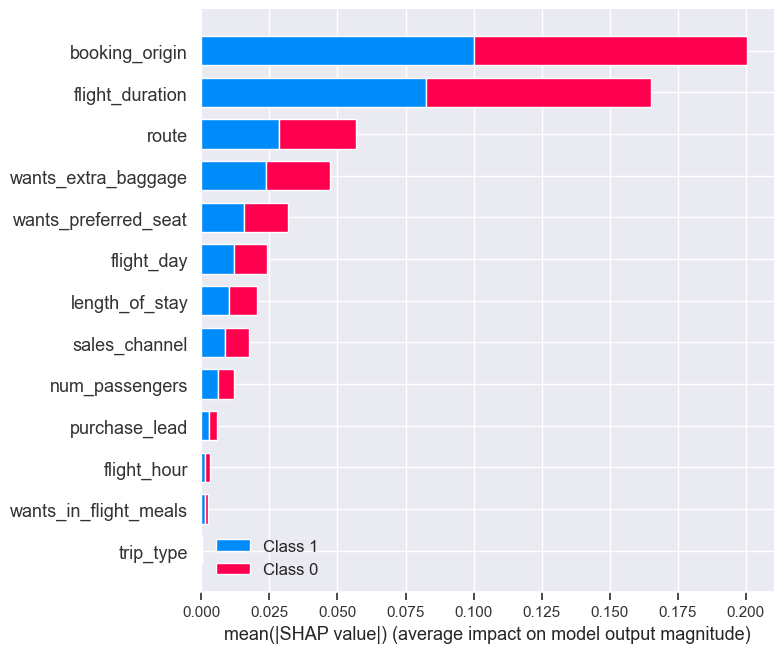

In [41]:
shap.summary_plot(shap_values, x_test)